#  LMS Exploration | 18. OCR_Verification

---


**[Introduce]** 
- OCR(Optical Character Recognition)은 오프라인의 글자를 기계가 읽을 수 있도록 디지털화하는 것입니다. 
- 딥러닝이 도입된 이후 [OCR 기술](https://blog.naver.com/kpostbank/221343765011)이 획기적으로 개선되어 많은 산업 도메인에 유용하게 사용될 수 있는 가능성이 열리고 있습니다. 
- 우편번호 추출을 통한 우편물 관리, 자동차 번호판 인식, 모바일 기기를 사용한 명함 인식, 신용카드 읽기를 이용한 결제 서비스, 컨테이너 일련번호 인식을 이용한 스마트 선박 시스템 등 다양한 OCR 기술 활용사례가 있습니다. 
- 문자인식의 과정은 문자검출(Detection)-문자인식(Recognition)의 과정으로 진행됩니다.
- [Google OCR API](https://cloud.google.com/vision), [keras-ocr](https://keras-ocr.readthedocs.io/en/latest/), [Tesseract](https://opensource.google/projects/tesseract) 의 기술검증을 해봅니다. 
- OCR 기능을 활용한 서비스를 신속히 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 해봅니다. 
- 아래의 순서로 진행해봅니다.
    - Step1. 검증용 데이터셋 준비
    - Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
    - Step3. 테스트 결과 정리
    - Step4. 결과 분석과 결론 제시


|평가문항|상세기준|
|--|--|
|1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?|목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.|
|2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?|평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.|
|3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?|최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.|


- **목표로 하는 서비스 : 손글씨 기록을 디지털화 (일기, 메모, 편지, 그래피티(graffiti) 등)**

# Step1. 검증용 데이터셋 준비 
- OCR의 성능에 영향을 미치는 요인들에는 **텍스트의 모양과 크기, 배치, 노이즈 등** 이 있습니다. 
- 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect 하고 recognize하는지를 검증하기 위한 손글씨 이미지 데이터를 모아봅니다. 
- 검증해야 할 항목별로 고루 이미지를 불러옵니다. 
- 손글씨를 중심으로 하여 size, placement, noize 세 가지 항목으로 분류하여 이미지를 로드합니다. 
- 이미지는 저작권이 없는 무료 이미지 사이트인 [unsplash](https://unsplash.com/s/photos/text)에서 빌려오겠습니다. 

In [1]:
#- 글씨 크기
size = [
    'https://source.unsplash.com/U2eUlPEKIgU/640x460',
    'https://source.unsplash.com/y21qF5V_k6Q',
    'https://source.unsplash.com/xZcWyykjZ6I',
]

#- 가로, 세로, 곡선 등 다양한 배치 
placement = [
    'https://source.unsplash.com/jTWdvjPx3c4',
    'https://source.unsplash.com/POMpXtcVYHo',
    'https://source.unsplash.com/c2x94-kmQcQ',
    'https://source.unsplash.com/IhWYiwSxm8g',
]

#- 노이즈
noize = [
    
    'https://source.unsplash.com/vIacHQ5ZqxY',
    'https://source.unsplash.com/_e1Y2YJiG7E',
    'https://source.unsplash.com/t56OrP9DSHo',
    'https://source.unsplash.com/J3yas-8gtWA'
]


In [2]:
#- 손글씨가 아닌 이미지(추가)
n_handwritten = [
    'https://source.unsplash.com/M7mu6jXlcns/640x460',
    'https://source.unsplash.com/6jsp4iHc8hI/640x460',
    'https://source.unsplash.com/j9JoYpaJH3A',
    'https://source.unsplash.com/eBkEJ9cH5b4'
]

# Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
- 이미지 리스트를 정리한 후, 반복문을 실행하며 모듈이 출력한 결과를 모아봅니다. 

## 2-1. Google OCR API

```python
#- 구글 파이썬 API 인터페이스 모듈 설치
! pip install --upgrade google-api-python-client
! pip install google-cloud-vision
```

```python
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
```

- detext_text는 이미지 파일을 입력으로 할 때 사용할 수 있는 함수입니다.
- 우리는 unsplash의 이미지 url을 입력으로 할 것이기 때문에 [detect_text_uri](https://cloud.google.com/vision/docs/samples/vision-text-detection-gcs?hl=ko) 함수를 이용합니다.  
- parse_image 함수는 이후 분석에 활용할 결과 리스트 my_formatted_text를 반환합니다.

In [3]:
def detect_text_uri(uri):
    """Detects text in the file located in Google Cloud Storage or on the Web.
    """
    from google.cloud import vision
    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

        vertices = (['({},{})'.format(vertex.x, vertex.y)
                    for vertex in text.bounding_poly.vertices])

        print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [4]:
def parse_image(uri):
    """
    Parse the image using Google Cloud Vision API, Detects "document" features in an image
    :param image_path: path of the image
    :return: text content
    :rtype: str
    """
    from google.cloud import vision

    client = vision.ImageAnnotatorClient()
    image = vision.Image()
    image.source.image_uri = uri
    response = client.text_detection(image=image)
    text = response.text_annotations
    
    image_content = text[0].description
    print(image_content)
    my_formatted_text = []
    for line in image_content.split("\n"):
        my_formatted_text.append(line)
    del response     # to clean-up the system memory

    return my_formatted_text

In [5]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'


for i in size:
    detect_text_uri(i)

Texts:

"DREAM
BIG.
"
bounds: (235,204),(537,204),(537,401),(235,401)

"DREAM"
bounds: (235,206),(536,204),(537,305),(236,307)

"BIG."
bounds: (297,319),(484,322),(483,401),(296,398)
Texts:

"If you
believe doy
in me like
I believe
in you,
they will
remember
us.
"
bounds: (494,409),(898,409),(898,925),(494,925)

"If"
bounds: (498,409),(562,415),(558,461),(494,456)

"you"
bounds: (589,418),(698,428),(693,477),(585,468)

"believe"
bounds: (498,479),(739,474),(740,524),(499,529)

"doy"
bounds: (800,466),(897,464),(898,531),(801,533)

"in"
bounds: (506,546),(590,546),(590,596),(506,596)

"me"
bounds: (596,557),(669,557),(669,590),(596,590)

"like"
bounds: (697,548),(839,548),(839,592),(697,592)

"I"
bounds: (532,605),(577,605),(576,664),(531,664)

"believe"
bounds: (580,605),(797,607),(796,666),(579,664)

"in"
bounds: (505,676),(591,682),(587,736),(501,730)

"you,"
bounds: (596,684),(723,693),(719,745),(592,736)

"they"
bounds: (497,749),(642,745),(643,802),(498,806)

"will"
bounds: (674,7

## 2-2. keras-ocr
- [keras-ocr](https://keras-ocr.readthedocs.io/en/latest/index.html)은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해줍니다.
- 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)을 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용합니다.
- keras_ocr.pipeline.Pipeline()은 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)을 불러오게 됩니다.

In [6]:
import matplotlib.pyplot as plt
import keras_ocr

#- keras-ocr이 detector와 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [7]:
def keras_ocr(image_urls):
    import keras_ocr
    import re
    images = [ keras_ocr.tools.read(url) for url in image_urls]
    prediction_groups = [pipeline.recognize([url]) for url in image_urls]
    texts = []
    
    
    for i in prediction_groups:
        #print(i)
        regex = re.compile(r"\'(.+?)\'") #- '' 로 감싸져있는 이미지에서 추출한 문자만 모두 찾아냅니다.
        text = regex.findall(str(i))
        #print(text)
        texts.append(text)
        
    print(texts)
        
    
  
    #- Plot the predictions
    fig, axs = plt.subplots(nrows=len(images), figsize=(20,20))
    for idx, ax in enumerate(axs):
            keras_ocr.tools.drawAnnotations(image=images[idx],
                                           predictions=prediction_groups[idx][0], ax=ax)
    
    return texts
    

- 내부적으로 recognize()는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 합니다.
- keras_ocr을 비교분석하기 위해서 이미지에서 추출한 텍스트를 리스트에 저장합니다. 
- 이때, prediction_groups는 아래와 같은 요소들의 리스트로 이뤄져 있습니다. 
```
[[('dream', array([[232., 205.],
       [544., 205.],
       [544., 301.],
       [232., 301.]], dtype=float32)), ('bie', array([[293.8731 , 322.74457],
       [461.54437, 329.9718 ],
       [458.43182, 402.18243],
       [290.76056, 394.9552 ]], dtype=float32))]]
```
- 따라서 정규식을 이용하여 '' 작은따옴표로 둘러 쌓여있는 문자(각 이미지에서 검출한 단어)를 추출하여 text 리스트에 저장하고, 항목에 해당하는 이미지들의 문자리스트를 담고있는 texts 리스트를 만듧니다.   

[['dream', 'bie'], ['tf', 'you', 'jono', 'believe', 'like', 'in', 'me', 'believe', 't', 'in', 'you', 'they', 'wil1', 'remember', 'us', 'r', 'dnn', 'ta'], ['share', 'love', 'not', 'hate']]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


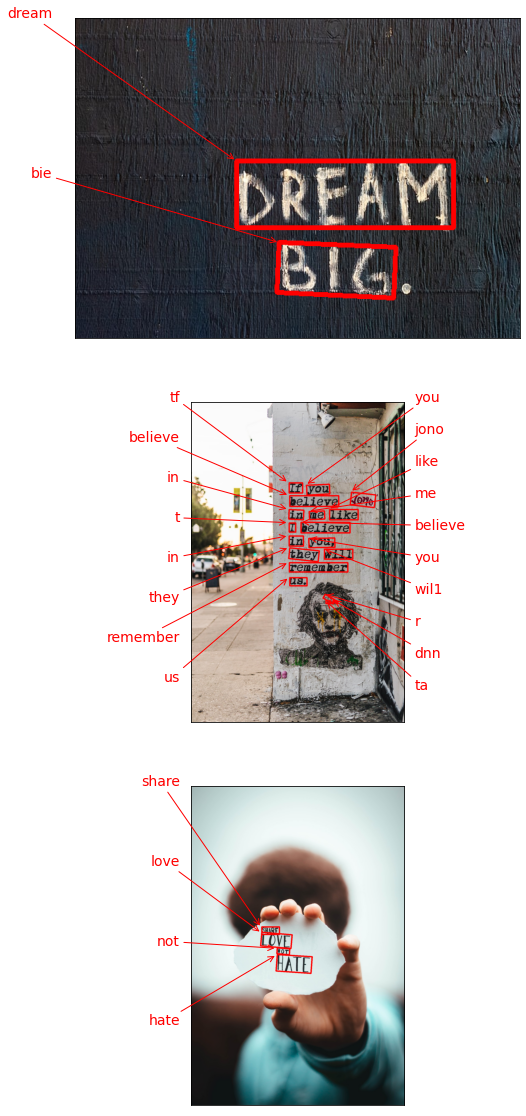

In [8]:
keras_size = keras_ocr(size)

[['shume', 's', 'where', 'uour', 'story', 'begins', 'an'], ['lo', 'en', 'ss', 'e', 'o', 'eis', 'cs', 'oi', 'se', 'd', 'r', 's', '2', 'w'], ['s'], ['m', 'r', 'so', 'un', 't', 'ten', 'e', 'co', 'rs', 'se']]


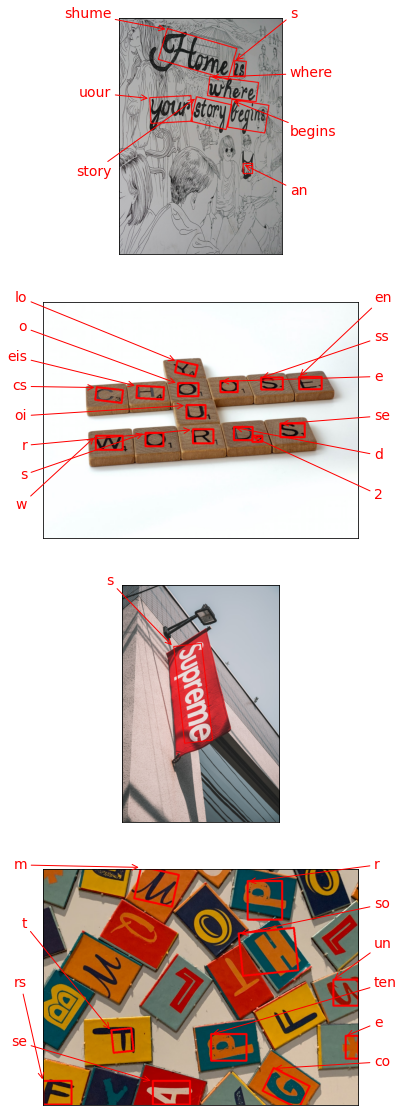

In [9]:
keras_placement = keras_ocr(placement)

[['hy', 'caed', 'm', 'mornings'], ['on', 'mang', 'csdis', 'ro', 'satos'], ['faltifilles', 'vitleiess', 'el', 'ontron', 'e'], ['cra', 'todd', 'yol', 'all', 'won', 'tove', 's', 'aeel', 'bd', 'bd', 'sove', 'cray', 'todd', 'copay', 'codd']]


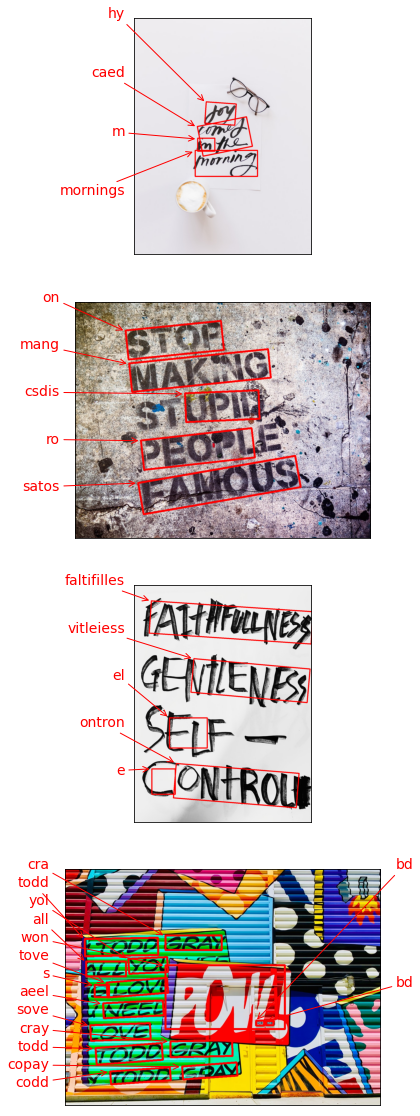

In [10]:
keras_noize = keras_ocr(noize)

```python
keras_ocr(noize)
keras_ocr(placement)
```

## 2-3. Tesseract

- 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용되고 있습니다. 
- 버전 4에서는 LSTM이 엔진에 추가되었고, 현재 한국어를 포함한 116개 국어를 지원하고 있습니다. 
- [pytesseract](https://pypi.org/project/pytesseract)는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼(wrapper) 라이브러리입니다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.
- crop_word_regions() 함수는 우리가 택한 테스트 이미지를 받아 문자 검출을 진행한 후에, 검출된 문자 영역을 crop 한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다. 
- 기본적으로 pytesseract.image_to_data()를 사용합니다. 
- 파이썬에서 편하게 사용하기 위해서 pytesseract의 Output을 사용해서 결괏값의 형식을 딕셔너리(DICT)형식으로 설정해주게 됩니다. 
- 이렇게 인식된 결과는 바운딩 박스의 left, top, width, hight 정보를 가지게 됩니다. 바운딩 박스를 사용해 이미지의 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴했습니다. 
- lang='kor'로 바꾸기 위해서는 [테서랙트의 언어팩](https://blog.daum.net/rayolla/1141)을 설치해야 합니다.

```python
#- 1) 테서랙트 설치
! sudo apt install tesseract-ocr
! sudo apt install libtesseract-dev

#- 2) 테서랙트 파이썬 wrapper 설치
! pip install pytesseract
! pip list | grep pytesseract
```

In [22]:
#- 3) 테서랙트로 문자 검출 및 이미지 자르기(detection)
import io
import requests
from PIL import Image

import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_url, output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    img_resp = requests.get(image_url)
    image = Image.open(io.BytesIO(img_resp.content))

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            #print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [23]:
#- 테서랙트로 잘린 이미지에서 단어 인식하기

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    texts = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result = recognized_data['text']
        arr = result.split('\n')[0:-1] 
        result = '\n'.join(arr)
        texts.append(result)
        
        #print(recognized_data['text'])
    print(texts)
    return texts

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.

```
arr = result.split('\n')[0:-1] 
result = '\n'.join(arr)
```
- '\n\x0c' 가 문자끝에 개입되기 때문에, 줄바꿈 \n을 기준으로 분리한 다음에 문제가 되는 마지막 줄을 제거한 후에 다시 줄바꿈 \n을 기준으로 합쳐주는 것입니다. 

# Step3. 테스트 결과 정리
- 모듈들마다 출력 형태가 다르기 때문에, 분석을 위해 pandas의 dataframe을 활용하여 결과를 일목요연하게 정리해봅니다.

In [13]:
#- 비교분석을 위해 각 항목별 데이터를 저장할 리스트를 생성합니다.

google_size = []
google_placement = []
google_noize = []

tesseract_size = []
tesseract_placement = []
tesseract_noize = []

In [14]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'

for i in size:
    google_ocr_txt = parse_image(i)
    cropped_image_path_list = crop_word_regions(i, work_dir)
    tesseract_ocr_txt = recognize_images(cropped_image_path_list)

    google_size.append(google_ocr_txt)
    tesseract_size.append(tesseract_ocr_txt)
    
for i in placement:
    google_ocr_txt = parse_image(i)
    cropped_image_path_list = crop_word_regions(i, work_dir)
    tesseract_ocr_txt = recognize_images(cropped_image_path_list)

    google_placement.append(google_ocr_txt)
    tesseract_placement.append(tesseract_ocr_txt)
       

for i in noize:
    google_ocr_txt = parse_image(i)
    cropped_image_path_list = crop_word_regions(i, work_dir)
    tesseract_ocr_txt = recognize_images(cropped_image_path_list)

    google_noize.append(google_ocr_txt)
    tesseract_noize.append(tesseract_ocr_txt)
       

DREAM
BIG.

['ear', 'Sie.']
If you
believe doy
in me like
I believe
in you,
they will
remember
us.

['bo WE', 'ay', '—— rl', ':', 'bol ious', 'Lory', ':', 'iay', '“a', 'Re', 'Sine;', 'es', 'I believe | ff', '11', 'you,', 'Ti)', 'they', 'will', '', '| , i', 'remember', 'ANP aE', '—_ fC', 'Wii', '', 'WI', '5 (']
SHARE
LOVE
NOT
HATE

['e 4']
tome is
where
your story begin

['yy 2', 'oe', '3', '7', '\\ |', '', '', 'LF', 'AV fag \\', '', 'wy)', 'head', '7', 'A/V \\', '/\\', '\\', 'Ihr', 'Nt', '4', '(', 'A', 'i', '‘ La', 'y \\/\\aE', '', '', 'NX', '', 'i', 'i ee 7 lay', ')', 'd', '', '', '|', 'SY', '—_ lll', 's', 'Ma Ty', '\\ |Z', '\\\\ei', '. ae', '\\', 'u/s', '}', '', '|', '', 'ae', 'Me', 'Q inl', '', 'I 7S', '', '']
C, H,
O, S, E,
W. O, R, D, S,

['']
Supreme

['\\', 'yy', 'Ns', '.', '', '', 'A', '', ',', '']
HT
F マ

['se:']
joy
in the
morning

['g']
STOP
MAKNG
STUPI
PEOPLE
FAMOUS

['3)']
GENLENES
SELF-
CONTROU

['']
TODD GRAY
ALL YOUT
SLOVE
U NEEL
LOVE
TODD GRAY
V TODD COAV
FOWL
BD BD

[

In [15]:
import pandas as pd

dict_size = {'google_ocr':google_size,'keras_ocr':keras_size, 'tesseract_ocr':tesseract_size}
dict_placement = {'google_ocr':google_placement,'keras_ocr':keras_placement, 'tesseract_ocr':tesseract_placement}
dict_noize = {'google_ocr':google_noize,'keras_ocr':keras_noize, 'tesseract_ocr':tesseract_noize}

df_size = pd.DataFrame(dict_size)
df_placement = pd.DataFrame(dict_placement)
df_noize = pd.DataFrame(dict_noize)

In [25]:
import os
from skimage import io
import matplotlib.pyplot as plt
def url2img(urls,figsize=(12,4)):
    
    plt.rcParams["figure.figsize"] = [9, 3.50]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure(figsize=figsize)
    rows = 1
    cols = len(urls)
    i = 1
    
    for j, url in enumerate(urls):
        a = io.imread(url)
        ax = fig.add_subplot(rows, cols, i)
        
        plt.title(f"picture{j}",fontsize=20)
        plt.axis('off')
        plt.imshow(a)
        i += 1
    fig.tight_layout()    
    plt.show()

## 3-1. Size
- 큰 사이즈부터 작은사이즈의 손글씨 이미지를 사용했습니다. 
- 모든 이미지에서 google_ocr는 문자를 정확히 검출해냈으며, 대소문자 구분도 정확합니다.
- keras_ocr은 높은 정답률을 보였지만, 대소문자 분별없이 모두 소문자로 출력하며, 대문자 G를 e로 혼동하는 모습을 보입니다(소문자만 인식?)
- tesseract_ocr은 큰글자~ 작은글자 관계없이 낮은 정답률을 보입니다. 

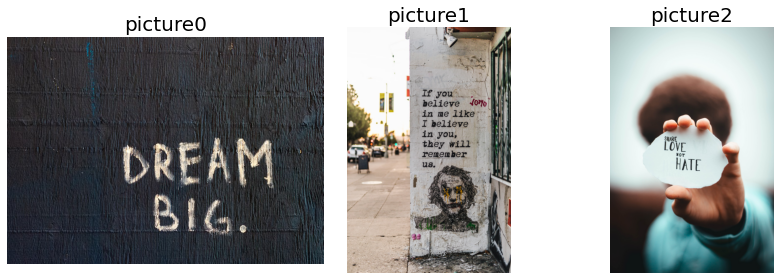

,google_ocr,keras_ocr,tesseract_ocr
0,"[DREAM, BIG., ]","[dream, bie]","[ear, Sie.]"
1,"[If you, believe doy, in me like, I believe, i...","[tf, you, jono, believe, like, in, me, believe...","[bo WE, ay, —— rl, :, bol ious, Lory, :, iay, ..."
2,"[SHARE, LOVE, NOT, HATE, ]","[share, love, not, hate]",[e 4]


In [17]:
url2img(size)
df_size

## 3-2. Placement
- 기울어지거나, 회전되어있는 문자이미지를 사용했습니다. 
- 마찬가지로 google_ocr이 가장 뛰어난 성능을 보입니다. 마지막 pic3의 쏟아져있는 알파벳 카드에서는 몇가지 문자밖에 인식하지 못했지만, pic0의 약간 기울어져있는 필기체 손글씨(H만 틀림), pic2의 90도 회전한 supreme을 정확하게 검출해냈습니다. pic1의 단어퍼즐에서 가로로 보이는 단어는 검출했지만, 세로로 되어있는 YOUR는 검출하지 못했습니다.
- keras_ocr은 pic0의 필기체를 잘 인식하는 편입니다. pic1에서는 단어퍼즐을 쪼개아 아래첨자까지 인식하려는 모습이 보입니다. pic2의 90도 회전한 문자는 첫글자만 검출했습니다. keras는 google_ocr과 달리 작은 단위로 쪼개진 문자를 더욱 잘 인식하는 것으로 보입니다. 
- tesseract_ocr은 pic0 필기체, pic1의 단어퍼즐, pic2의 90도 회전한 문자, pic3의 쏟아진 알파벳카드 모두 전혀 인식하지 못했습니다. 

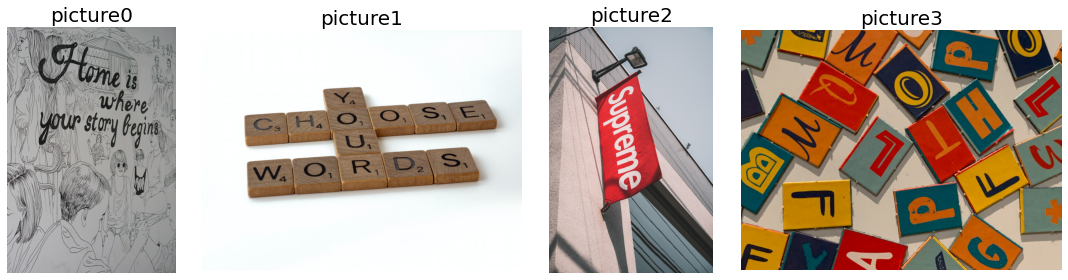

,google_ocr,keras_ocr,tesseract_ocr
0,"[tome is, where, your story begin, ]","[shume, s, where, uour, story, begins, an]","[yy 2, oe, 3, 7, \ |, , , LF, AV fag \, , wy),..."
1,"[C, H,, O, S, E,, W. O, R, D, S,, ]","[lo, en, ss, e, o, eis, cs, oi, se, d, r, s, 2...",[]
2,"[Supreme, ]",[s],"[\, yy, Ns, ., , , A, , ,, ]"
3,"[HT, F マ, ]","[m, r, so, un, t, ten, e, co, rs, se]",[se:]


In [18]:
url2img(placement,(16,4))
df_placement

## 3-3. Noize 
- 배경에 요란한 노이즈가 있거나, 글씨 자체가 삐뚤빼뚤 노이즈가 있는 경우입니다. 
- google_ocr은 손글씨에 강하다는 것을 알 수 있습니다. pic1의 필기체도 완벽히 검출해네고, pic1의 오염된 부분인 D 빼고는 잘 검출해냈습니다. pic2에서 많이 삐뚤어진 "FAItHFuLLNESS"는 아예 검출해내지 않는 모습을 보입니다. 어쩌면 소문자와 대문자가 섞여있는 것도 방해가 된 것 같습니다. 요란한 배경이 있는 pic3에서도 문자를 정확히 검출해냅니다.
- keras는 필기체를 인식할 수는 있지만 아직 입문자로 보입니다. 배경에 노이즈가 있는 나머지 그림에서 문자를 잘 검출해내지 못합니다.
- tesseract_ocr은 아예 문자를 검출해내지 못하고 있습니다. 노이즈에 굉장히 약한 것으로 보입니다. 

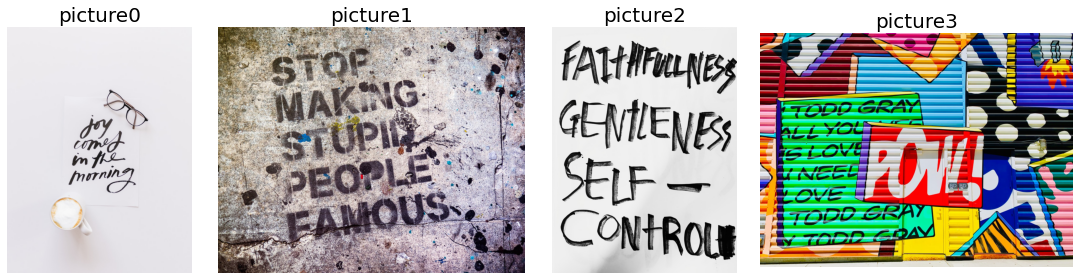

,google_ocr,keras_ocr,tesseract_ocr
0,"[joy, in the, morning, ]","[hy, caed, m, mornings]",[g]
1,"[STOP, MAKNG, STUPI, PEOPLE, FAMOUS, ]","[on, mang, csdis, ro, satos]",[3)]
2,"[GENLENES, SELF-, CONTROU, ]","[faltifilles, vitleiess, el, ontron, e]",[]
3,"[TODD GRAY, ALL YOUT, SLOVE, U NEEL, LOVE, TOD...","[cra, todd, yol, all, won, tove, s, aeel, bd, ...","[ee errr ee, , i&-, ae, At, ff, J - lc ;ewU T..."


In [19]:
url2img(noize,(16,4))
df_noize

## 3-4. 손글씨가 아닌 문자 (추가)
- google_ocr을 제와한 keras_ocr과 (특히)tesseract_ocr의 성과가 너무 안좋아서, 손글씨가 아닌 정형화된 문자에 대해 추가로 비교분석해보았습니다. 


```python
keras_n_handwritten = keras_ocr(n_handwritten)
```

```python
google_n_handwritten = []
tesseract_n_handwritten = []

for i in n_handwritten:
    google_ocr_txt = parse_image(i)
    cropped_image_path_list = crop_word_regions(i, work_dir)
    tesseract_ocr_txt = recognize_images(cropped_image_path_list)

    google_n_handwritten.append(google_ocr_txt)
    tesseract_n_handwritten.append(tesseract_ocr_txt)
    
dict_n_handwritten = {'google_ocr':google_n_handwritten,'keras_ocr':keras_n_handwritten, 'tesseract_ocr':tesseract_n_handwritten}
df_n_handwritten = pd.DataFrame(dict_n_handwritten) 
```

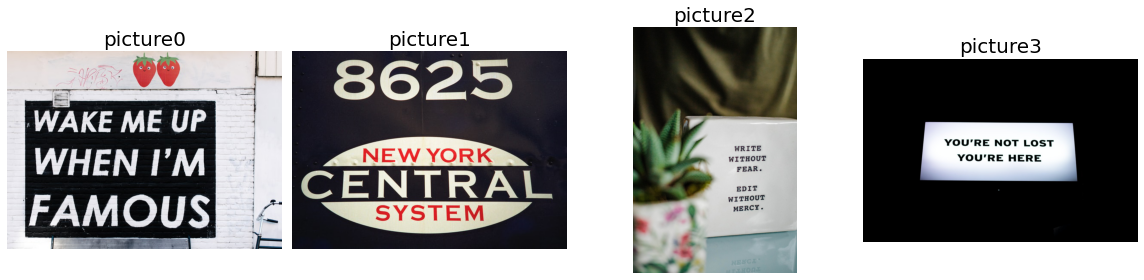

,google_ocr,keras_ocr,tesseract_ocr
0,"[WAKE ME UP, WHEN I'M, FAMOUS, ]","[up, wake, me, wheni, im, famous]",[]
1,"[8625, NEW YORK, CENTRAL, SYSTEM, ]","[8624, new, york, central, system]","[Sic pPbo., a, a, - NEw YoRK —™, a, CENTRAL, a..."
2,"[WRITE, WITHOUT, FEAR., EDIT, WITHOUT, MERCY.,...","[write, without, fearo, edit, without, mercya,...","[WRITE, WITHOUT, FEAR., EDIT, WITHOUT, MERCY.,..."
3,"[YOU'RE NOT LOST, YOU'RE HERE, ]","[youre, not, lost, youre, here]","[YOU'RE, NOT, LOST, YOU'RE, reer Ee., | “you'r..."


In [26]:
url2img(n_handwritten,(16,4))
df_n_handwritten

- google_ocr은 모든 결과가 "완벽"합니다. 대소문자, 숫자, 문장부호(')까지 완벽히 검출해냅니다.
- keras_ocr은 소문자, 숫자는 검출이 가능하지만, 대문자와 문장부호는 검출해내지 못합니다. 문장부호가 무시되고, 가끔 없는 단어가 추가되었긴 하지만 좋은 성능을 보입니다. 
- tesseract_ocr은 명확한 프린팅도 잘 검출해내지 못하고 있습니다. pic0은 아주 조금 기울어져 있음에도 전혀 문자인식을 못하고 있습니다. pic1에서는 제 눈에는 보이지 않는 문자들을 검출해내고 있습니다.. 숫자인식은 못하는 것으로 보입니다. 반면 윗첨자나 문장부호를 알고 있고, 대소문자 구분도 가능해보입니다. pic2, pic3의 문자는 그런데로 잘 검출해내고 있지만, pic0, pic1의 문자는 제대로 검출하지 못하고 있습니다.  

# Step4. 결과 분석과 결론 제시
- 구현하고자 하는 서비스는 손글씨 데이터를 디지털화 하는 것입니다. 일기, 낙서, 그래피티와 같은 비정형화된 손글씨 문자를 검출해내고자 합니다. 
- 우리가 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준으로 "텍스트의 크기", "배치", "노이즈" 로 선정했습니다. 
- 그 기준에 따라 위에서 정리한 테스트 결과를 분석한 결과 Google OCR 모델이 가장 뛰어난 성능을 보였으며, Tesseract가 가장 낮은 성능을 보입니다. 
- Google OCR은 대소문자, 문장부호, 숫자까지 검출이 가능했으며, 평가항목 모두에서 높은 성능을 보였습니다. 
- Keras OCR은 대소문자, 문장부호의 구별이 불가능(only 소문자)하지만, 문자의 크기변화에는 높은 정확도를 보였습니다. 반면 문자가 회전되거나 흐트러진 경우엔 정확도가 낮아졌으며, 배경 또는 문자에 노이즈가 있는 경우에는 정확도가 큰 폭으로 감소했습니다. 
- Tesseract는 대소문자, 문장부호, 숫자의 검출이 가능하지만, 비정형화된 문자에 적합하지 않다는 것을 확인할 수 있었습니다. 손글씨로 테스트한 결과 모든 항목에서 정답을 맞추지 못했습니다. 이후 추가로 정형화된 문자(printing)으로 테스트 했을 때, 아주 미세한 배치변화나 노이즈에도 민감하게 반응한다는 것을 확인했습니다. 
- 따라서 '손글씨 데이터를 디지털화'할때 가장 적합한 OCR 모델은 Google OCR 입니다.


|평가기준|Google OCR API|keras-ocr|Tesseract|
|---|---|---|---|
|텍스트의 모양과크기|상|중상|하|
|배치|상하|중상|하|
|노이즈|상하|하|하|

---

(추가)

- Tesseract의 한계
    - OCR은 일부 상용 솔루션만큼 정확하지 않습니다.
    - 부분 폐색, 왜곡 된 원근 및 복잡한 배경을 포함하여 아티팩트의 영향을받는 이미지에는 적합하지 않습니다.
    - 손글씨를 인식 할 수 없습니다.
    - 횡설수설을 찾아 OCR 출력으로보고 할 수 있습니다.
    - 문서에 -l LANG 인수에 지정된 언어 이외의 언어가 포함 된 경우 결과가 좋지 않을 수 있습니다.
    - 문서의 자연스러운 읽기 순서를 분석하는 것이 항상 좋은 것은 아닙니다. 예를 들어 문서에 두 개의 열이 있다는 것을 인식하지 못하고 여러 열에 걸쳐 텍스트를 결합하려고 할 수 있습니다.
    - 스캔 품질이 좋지 않으면 OCR 품질이 떨어질 수 있습니다.
    - 글꼴 패밀리 텍스트가 속하는 것에 대한 정보는 노출하지 않습니다.
    - 참고 : [Tesseract, OpenCV 및 Python을 활용한 OCR](https://ichi.pro/ko/tesseract-opencv-mich-python-eul-sayonghan-ocr-231743215466598)
- Tesseract는 깨끗한 문서를 스캔하는 데 적합하다고 합니다.. 

- google_ocr, keras_ocs, tesseract가 각각 어떻게 다르게 동작하기에 이처럼 다른 결과를 가져오는 것일지 간략히 알아봅시다. 

- To Be Continued...